In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing
import os
import sys
from scipy.ndimage import gaussian_filter1d
from scipy.signal import convolve
from brian2 import *

In [3]:
sys.path.append("../lib") # add code library to paths

# add lib to path 
from model_beta import Model



In [4]:
# TODO: turn this into  script

In [5]:
netname = 'recurrent_nn'
model = Model(netname)  # initiate the model


../output/recurrent_nn


In [8]:
params = {
'sig_c' : 0.05  ,    # bipolar receptive fied size ~ 1/5 of the actual size [mm]
'tau1' : 0.04   ,    # excitation time constant of the temporal filter [s]
'tau2' : 0.0876 ,    # rebound time constant [s]
'bifw' : 0.     ,    # relative weight of rebound/excitation [1]

'scale_mV' : 20.,     # UPDATED 

'tauA' : 0.15   ,     # time constant of amacrine cells [s]
'tauB' : 0.08   ,     # time constant of bipolar cells [s]
'tauG' : 0.01   ,     # time contant of ganglion cells [s]

'wAB' : 10.     ,     # synaptic weight from bipolar to amacrine [Hz]
'wBA' : -10.    ,     # synaptic weight from amacrine to bipolar [Hz]
'wGB' : 4.0     ,     # synaptic weight from bipolar to gangion  [Hz].   #UPDATED
'wGA' : 0.      ,     # synaptic weight from amacrine  to gangion  [Hz]

'slope' : 5     ,     # slope for ganglion cell recritifation [Hz/mV].   #UPDATED
'threshold' : 0 ,     # threshold for ganglion cell recritifation [Hz/mV]
'sig_pool' : 0.065 ,  # sigma for gaussian pooling in ganlion gells [mm]


'spacing' : 0.005  ,  # spacing of cells on the lattice [mm]
'dt' : 0.001      ,   # integration time step [s]
'N' : 512          ,  # number of neurons in each layer [1]


# idx = int(N/2)
# b =  0.160         # half bar width [mm]
# speed =  0.8       # speed [mm/s]  
}


In [9]:

# create connectivity matrix TODO write a class for this !!!

C = np.zeros((params['N'],params['N']))
ii = np.arange(0,params['N']-1,1).astype(int)  # list of source cells for rightward connections
ji = ii + 1                          # target cells of rightward connections


C[ii,ji] = 1

ii = np.arange(1,params['N'],1).astype(int)    # list of source cells for leftward connections
ji = ii - 1                         # target cells of leftward connections

C[ii,ji] = 1


In [10]:

model.set_params(params)
model.set_connectivity(C)


# simulate response to global impulse

In [11]:

dur = 3.                      # duration of the simulation [s]
tps = int(dur/params['dt'])             # number of time-points in the simulation [1]
time = np.arange(0,tps)*params['dt']    # time array for the simulation 1xtps, in [s]

# initialize the stimulus
S = np.zeros((params['N'],tps))
S[:,int(tps/2)] = 1


In [12]:
model.set_stimulus(S,'gImpulse')
model.simulate()

../output/recurrent_nn/gImpulse


# simulate response to local Impulse

In [20]:

dur = 3.                      # duration of the simulation [s]
tps = int(dur/params['dt'])             # number of time-points in the simulation [1]
time = np.arange(0,tps)*params['dt']    # time array for the simulation 1xtps, in [s]

# initialize the stimulus
S = np.zeros((params['N'],tps))
S[206,int(tps/2)] = 1/params['dt']*0.05


In [21]:
model.set_stimulus(S,'lImpulse')
model.simulate()

../output/recurrent_nn/lImpulse


# loop over parameter for frequency grid

In [22]:
# loop over paramerter and save response, steady state
import pandas as pd
import joblib
from joblib import Parallel,delayed

joblib.cpu_count()

8

In [24]:
from scipy.fft import fft, fftfreq

def main_frequency(signal, sampling_rate):
    """
    Calculate the main frequency of a signal.

    Parameters:
    signal (numpy array): The input signal (time domain).
    sampling_rate (float): The sampling rate of the signal in Hz.

    Returns:
    float: The main frequency of the signal in Hz.
    """
    # Number of samples in the signal
    N = len(signal)

    # Perform the Fast Fourier Transform (FFT)
    fft_values = fft(signal)

    # Get the corresponding frequencies
    frequencies = fftfreq(N, d=1/sampling_rate)

    # Only consider the positive frequencies (as FFT produces symmetric output)
    positive_frequencies = frequencies[:N // 2]
    positive_fft_values = np.abs(fft_values[:N // 2])

    # Find the frequency with the maximum amplitude in the FFT result
    main_freq_index = np.argmax(positive_fft_values)
    main_freq = positive_frequencies[main_freq_index]

    return main_freq

In [36]:

wBAs = np.arange(1,25,1)
tauAs = np.round(np.logspace(0,1)*0.02,3)
# wBAs = wBAs[::10]
# tauAs = tauAs[::10]


print(len(wBAs),len(tauAs))


df = pd.DataFrame(columns = ['BC206', 'f','wBA','tauA'])
measure_point = int(2.9/params['dt'])



dur = 2.                                # duration of the simulation [s]
tps = int(dur/params['dt'])             # number of time-points in the simulation [1]
time = np.arange(0,tps)*params['dt']    # time array for the simulation 1xtps, in [s]

start = int(1./params['dt'])
stop  = int(3./params['dt']) 


# initialize the stimulus
S = np.zeros((params['N'],tps))
S[:,int(tps/2)] = 1

model.set_stimulus(S,'gImpulse')
model.dt = 0.01

grid = np.array(np.meshgrid(wBAs,tauAs)).T.reshape(-1,2)

def run_one(par):


        wBA = par[0]
        tauA= par[1]
        params['tauA'] = tauA
        params['wBA'] = -1*wBA

        model.set_params(params)
        BC206 = model.simulate(save = False)
        f = main_frequency(BC206, model.dt)
    

        dict = {'BC206': BC206,
                'wBA': wBA,
                'tauA': tauA,
                'f' : f
                }
        
        return dict



X = Parallel(n_jobs = 7, verbose=10)(delayed(run_one)(g) for g in grid)


for xi in X:
        df.loc[len(df)] = xi

#save dataframe 
df.to_csv(f'{model.dir}/{model.stimname}/grid_frequency.csv')


3 5
../output/recurrent_nn/gImpulse


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.


[Parallel(n_jobs=7)]: Done   4 out of  15 | elapsed:   46.4s remaining:  2.1min
[Parallel(n_jobs=7)]: Done   6 out of  15 | elapsed:   47.4s remaining:  1.2min
[Parallel(n_jobs=7)]: Done   8 out of  15 | elapsed:  1.6min remaining:  1.4min
[Parallel(n_jobs=7)]: Done  10 out of  15 | elapsed:  1.6min remaining:   47.9s
[Parallel(n_jobs=7)]: Done  12 out of  15 | elapsed:  1.6min remaining:   24.0s
[Parallel(n_jobs=7)]: Done  15 out of  15 | elapsed:  2.1min finished


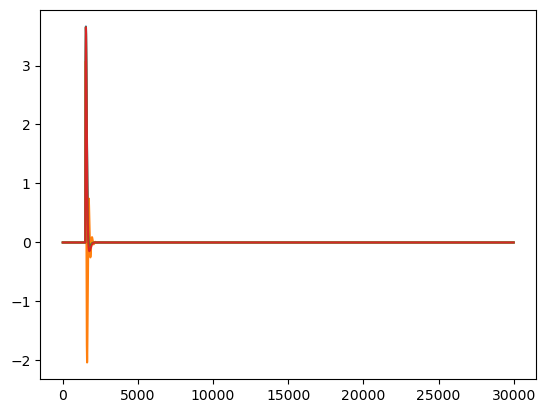

In [ ]:
plt.plot(df['BC206'].values[0])
plt.plot(df['BC206'].values[-1])
plt.plot(df['BC206'].values[2])
plt.plot(df['BC206'].values[3])

In [35]:
len(df)
for i in range(len(df)):
    print(main_frequency(df['BC206'].values[i],model.dt))

0.0
0.0
4.333333333333334e-06
1.3000000000000001e-05
1.5e-05
1.6666666666666667e-05
2.6333333333333334e-05
3.3333333333333335e-05
3.5333333333333336e-05
3.5333333333333336e-05
2.5e-05
3.8e-05
4.5333333333333335e-05
4.7000000000000004e-05
4.7000000000000004e-05
